## Step 1: Prepare the dataset

Import the required functions an define the search images function to download images using duckduckgo

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Test the search_images function by searching for 'Planet Mercury' and display the first url

In [ ]:
urls = search_images('Planet Mercury', max_images=1)
urls[0]

Searching for 'Planet Mercury'


'http://www.messagetoeagle.com/wp-content/uploads/2015/11/mercurynasa.jpg'

Download the image from the first url and save it to 'mercury.jpg'

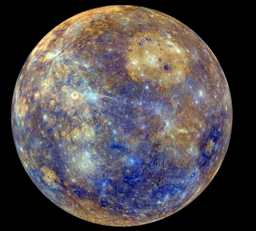

In [5]:
from fastdownload import download_url
dest = 'mercury.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with 'Planet Venus'

Searching for 'Plane Venus'


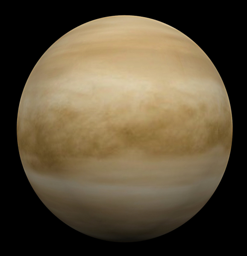

In [7]:
download_url(search_images('Plane Venus', max_images=1)[0], 'venus.jpg', show_progress=False)
Image.open('venus.jpg').to_thumb(256,256)

Now that we are able to download and save images properly. It's time to download and organize our dataset. We dowload the images by itearating through a list 'searches' which has all the planet names and we save the images to the respective folder with the label as the folder name.

In [8]:
searches = 'Mercury','Venus','Earth','Mars','Jupiter','Saturn','Uranus','Neptune'
path = Path('dataset')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'Planet {o}'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Planet Mercury'
Searching for 'Planet Venus'
Searching for 'Planet Earth'
Searching for 'Planet Mars'
Searching for 'Planet Jupiter'
Searching for 'Planet Saturn'
Searching for 'Planet Uranus'
Searching for 'Planet Neptune'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

Prepare the DataBlock and then dataloaders

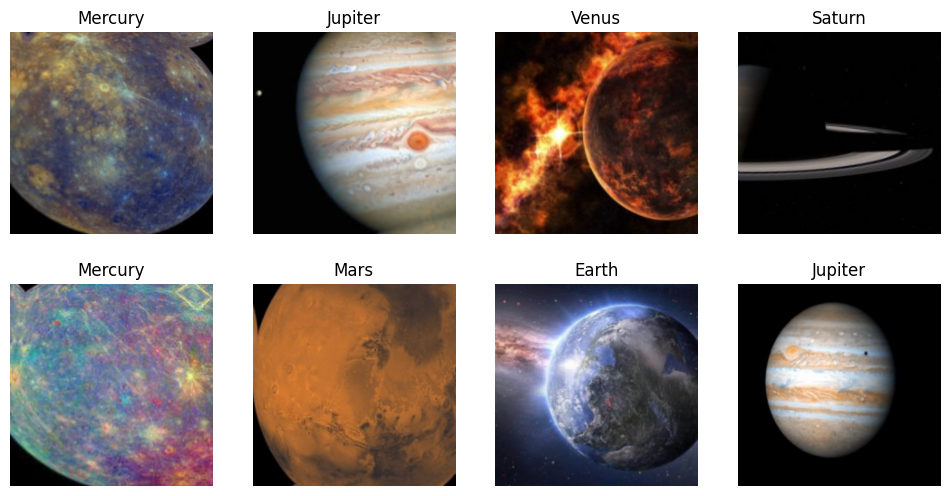

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

Train the model using transfer learning on the resnet model.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/home/harsha/mambaforge/envs/ai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/harsha/mambaforge/envs/ai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.140929,0.488398,0.194805,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.643321,0.391511,0.116883,00:03
1,0.485300,0.458462,0.149351,00:03
2,0.430538,0.438090,0.136364,00:03
3,0.342715,0.431272,0.129870,00:03


Get the Classification Interpretation and plot the confusion matrix

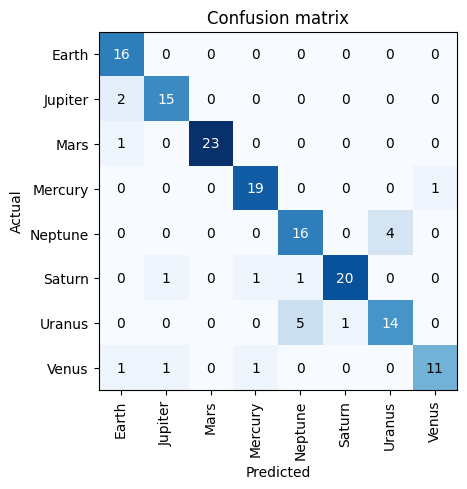

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Step 3: Export our model to be used for inference

In [13]:
learn.export('planets.pkl')